# Guided Project: Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.fanaee.com/) at the [University of Porto](https://sigarra.up.pt/up/pt/web_base.gera_pagina?p_pagina=home) compiled this data into a CSV file, which we will be working with in this project. The file contains `17380` rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

- `instant`: record index
- `dteday` : date
- `season` : season (1:winter, 2:spring, 3:summer, 4:fall)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month (1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : weather day is holiday or not (extracted from [Web Link])
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- `atemp`: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

In this project, we will try to predict the total number of bikes people rented in a given hour. We will predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, we will create a few different machine learning models and evaluate their performance.

Let's start by reading in the dataset and visualising some of the data.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [116]:
bike_rentals = pd.read_csv('bike_rental_hour.csv', index_col='instant')
bike_rentals.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


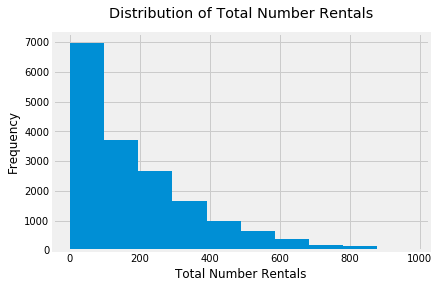

In [117]:
plt.hist(bike_rentals['cnt'])
plt.title('Distribution of Total Number Rentals', y=1.04)
plt.xlabel('Total Number Rentals')
plt.ylabel("Frequency")
plt.show()

In [118]:
cnt_corr = bike_rentals.corr()['cnt'].sort_values(ascending=False)
cnt_corr

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

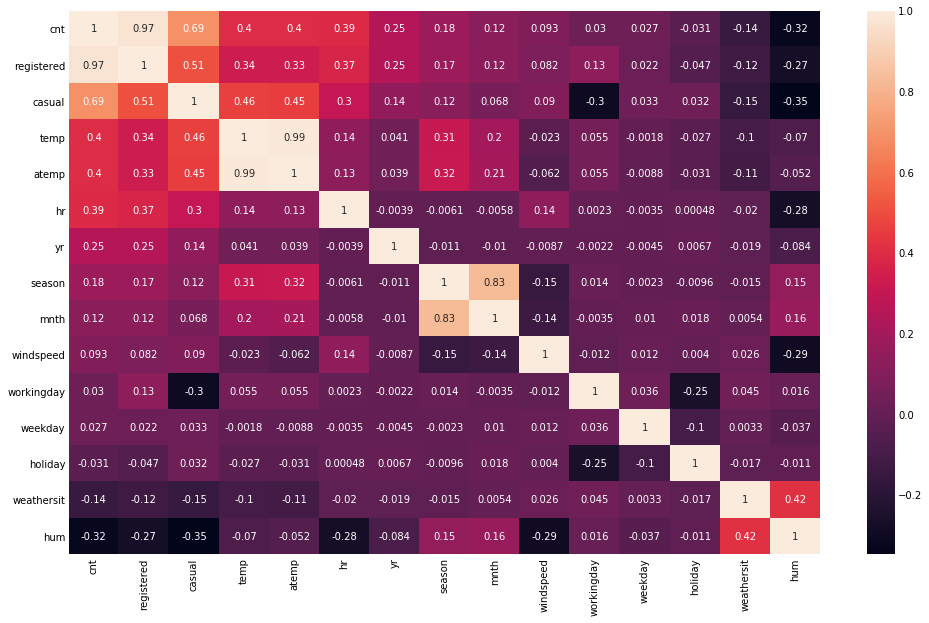

In [119]:
plt.figure(figsize=(15, 10))
sns.heatmap(bike_rentals[cnt_corr.index].corr(), annot=True)

## Calculating Features

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from `1` to `24`. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for `morning`, `afternoon`, `evening`, and `night`. This will bundle similar times together, enabling the model to make better decisions.

In [120]:
def assign_label(x):
    """
     Takes in a numeric value for an hour, and returns:
    - 1 if the hour is from 6 to 12
    - 2 if the hour is from 12 to 18
    - 3 if the hour is from 18 to 24
    - 4 if the hour is from 0 to 6
    """
    
    if x >= 6 and x < 12:
        return 1
    elif x >= 12 and x < 18:
        return 2
    elif x >= 18 and x < 24:
        return 3
    elif x >= 0 and x < 6:
        return 4

In [121]:
#Let's apply the `assign_label` finction to the `hr` column and create a new column - `time_label`

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

bike_rentals.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
instant,,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Splitting the Data Into Train and Test Sets

Before we can begin applying machine learning algorithms, we will need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting.

The error metrics which we will use are Mean Square Error (MSE) and Root Mean Squared Error (RMSE).

Let's split the dataframe in two:

- `train` - containing 80% of the rows from the original dataframe
- `test` - containing the remaining 20%

In [122]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.drop(train.index)

## Applying Linear Regression

Now that we have done some exploration and manipulation, we are ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with `cnt`.

Let's start by creating a predictor columns list. We will exclude the `cnt` column as it is our target column. We will also exlude the `casual` and `register` columns as they make up the `cnt` column. The `dteday` column will aslo be removed.

In [123]:
#Let's create a list of predictor columns

columns = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label']

In [133]:
lr = LinearRegression()
lr.fit(train[columns], train['cnt'])

train_predictions = lr.predict(train[columns])
test_predictions = lr.predict(test[columns])

train_lr_mse = mean_squared_error(train['cnt'], train_predictions)
test_lr_mse = mean_squared_error(test['cnt'], test_predictions)


print("MSE Train: {}\nMSE Test: {}".format(train_lr_mse, test_lr_mse))
print("*"*20)
print("RMSE Train: {}\nRMSE Test: {}".format(np.sqrt(train_lr_mse), np.sqrt(test_lr_mse)))

var1 = np.var(test_predictions)

MSE Train: 17460.42904103474
MSE Test: 17565.55493086445
********************
RMSE Train: 132.13791674245033
RMSE Test: 132.53510829536623


The error is quite high. However, we see that the train and test error metrics are pretty close. That means that the model preforms equally on data it hasn't seen.

## Applying Decision Trees

Now we are ready to apply the decision tree algorithm. We will be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set.

In [125]:
from sklearn.tree import DecisionTreeRegressor

In [134]:
#Let's first try without specifying the minimum samples per leaf:

tree = DecisionTreeRegressor()
tree.fit(train[columns], train['cnt'])

train_predictions = tree.predict(train[columns])
test_predictions = tree.predict(test[columns])

train_tree_mse = mean_squared_error(train['cnt'], train_predictions)
test_tree_mse = mean_squared_error(test['cnt'], test_predictions)


print("MSE Train: {}\nMSE Test: {}".format(train_tree_mse, test_tree_mse))
print('*'*20)
print("RMSE Train: {}\nRMSE Test: {}".format(np.sqrt(train_tree_mse), np.sqrt(test_tree_mse)))

var2 = np.var(test_predictions)

MSE Train: 0.23872545493778322
MSE Test: 3863.2256185270426
********************
RMSE Train: 0.4885953898040619
RMSE Test: 62.1548519306984


In [135]:
#Now let's specify the minimum samples per leaf:

tree = DecisionTreeRegressor(min_samples_leaf=5)
tree.fit(train[columns], train['cnt'])

train_predictions = tree.predict(train[columns])
test_predictions = tree.predict(test[columns])

train_tree_mse_5 = mean_squared_error(train['cnt'], train_predictions)
test_tree_mse_5 = mean_squared_error(test['cnt'], test_predictions)


print("MSE Train: {}\nMSE Test: {}".format(train_tree_mse_5, test_tree_mse_5))
print('*'*20)
print("RMSE Train: {}\nRMSE Test: {}".format(np.sqrt(train_tree_mse_5), np.sqrt(test_tree_mse_5)))

var3 = np.var(test_predictions)

MSE Train: 1178.9469298050324
MSE Test: 2809.886694692818
********************
RMSE Train: 34.33579662400499
RMSE Test: 53.00836438424428


The accuracy of the predictions improves under Decision Tree. When we specify the minimum smaples per leaf, we achieve even better results.

## Applying Random Forests

We can now apply the random forest algorithm, which improves on the decision tree algorithm.

In [128]:
from sklearn.ensemble import RandomForestRegressor

In [137]:
#Let's first try without specifying the minimum samples per leaf:

fr = RandomForestRegressor()
fr.fit(train[columns], train['cnt'])
train_predictions = fr.predict(train[columns])
test_predictions = fr.predict(test[columns])

train_fr_mse = mean_squared_error(train['cnt'], train_predictions)
test_fr_mse = mean_squared_error(test['cnt'], test_predictions)


print("MSE Train: {}\nMSE Test: {}".format(train_fr_mse, test_fr_mse))
print('*'*20)
print("RMSE Train: {}\nRMSE Test: {}".format(np.sqrt(train_fr_mse), np.sqrt(test_fr_mse)))

var4 = np.var(test_predictions)

MSE Train: 250.6835784006829
MSE Test: 1915.5521836863093
********************
RMSE Train: 15.832990191390978
RMSE Test: 43.76702164514178


In [138]:
#Now let's specify the minimum samples per leaf:

fr = RandomForestRegressor(min_samples_leaf=5)
fr.fit(train[columns], train['cnt'])

train_predictions = fr.predict(train[columns])
test_predictions = fr.predict(test[columns])

train_fr_mse_5 = mean_squared_error(train['cnt'], train_predictions)
test_fr_mse_5 = mean_squared_error(test['cnt'], test_predictions)


print("MSE Train: {}\nMSE Test: {}".format(train_fr_mse_5, test_fr_mse_5))
print('*'*20)
print("RMSE Train: {}\nRMSE Test: {}".format(np.sqrt(train_fr_mse_5), np.sqrt(test_fr_mse_5)))

var5 = np.var(test_predictions)

MSE Train: 1135.3771595508078
MSE Test: 1932.7304691816032
********************
RMSE Train: 33.69535813062102
RMSE Test: 43.962830541055965


Random Forests gives more accurate results than Decision Trees.

## Conclusion

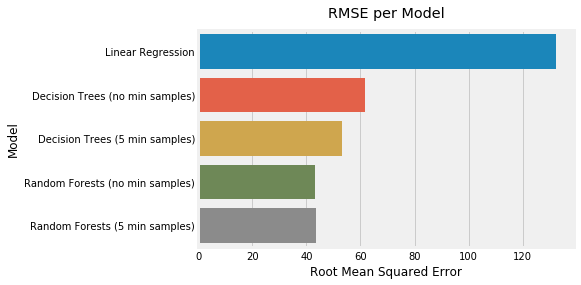

In [131]:
mses = [test_lr_mse, test_tree_mse, test_tree_mse_5, test_fr_mse, test_fr_mse_5]
rmses = np.sqrt(mses)

models = ['Linear Regression', 'Decision Trees (no min samples)', 'Decision Trees (5 min samples)',
         'Random Forests (no min samples)', 'Random Forests (5 min samples)']


ax = plt.subplot()
sns.barplot(rmses, models, orient='h')
plt.xlabel('Root Mean Squared Error')
plt.ylabel('Model')
plt.title('RMSE per Model', y=1.03)
plt.show()

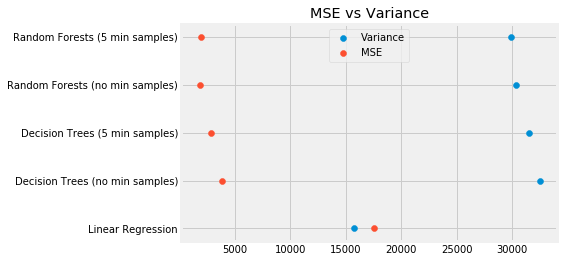

In [164]:
var = [var1, var2, var3, var4, var5]

plt.scatter(x=var, y=models, label='Variance')
plt.scatter(x=mses, y=models, label='MSE')
plt.legend(loc='upper center')
plt.title('MSE vs Variance')
plt.show()

In four out of the above five models ('Decision Trees (no min samples)', 'Decision Trees (5 min samples)', 'Random Forests (no min samples)', 'Random Forests (5 min samples)'), the out-of-sample error is much higher than the in-sample error. This means that the models do not generalize well outside the training set.

Steps for improvment could include:

- calculating additional features;
- trying to predict `casual` and `registered` instead of `cnt`.